### DSPT6 - Adding Data Science to a Web Application

The purpose of this notebook is to demonstrate:
- Simple online analysis of data from a user of the Twitoff app or an API
- Train a more complicated offline model, and serialize the results for online use

In [1]:
import sqlite3
import pickle
import pandas as pd

In [2]:
# Connect to sqlite database
conn = sqlite3.connect('/Users/yinmialas/Desktop/DS_unit3_yinmialas_twitoff/twitoffdemo.sqlite3')

In [3]:
def get_data(query, conn):
    '''Function to get data from SQLite DB'''
    
    cursor = conn.cursor()
    result = cursor.execute(query).fetchall()

    # Get columns from cursor object
    columns = list(map(lambda x: x[0], cursor.description))

    # Assign to DataFrame
    df = pd.DataFrame(data=result, columns=columns)
    return df

In [5]:
import pickle

sql = '''
SELECT 
	tweet.id,
	tweet.tweet, 
	tweet.embedding,
	user.username
FROM tweet
JOIN user on tweet.user_id = user.id;
'''

df = get_data(sql, conn)
df['embedding_decoded'] = df.embedding.apply(lambda x: pickle.loads(x))
print(df.shape)
df.head(3)

(12291, 5)


,id,tweet,embedding,username,embedding_decoded
0,23048456524,"Worth a read, I liked this Economist article a...",b'\x80\x04\x95\xee\x11\x00\x00\x00\x00\x00\x00...,billgates,"[-0.07537176, 0.27606362, -0.0547825, 0.014415..."
1,23048600560,"Another interesting article, this one on a pro...",b'\x80\x04\x95\xee\x11\x00\x00\x00\x00\x00\x00...,billgates,"[-0.14114963, 0.17626844, -0.18227336, 0.10240..."
2,24514937071,The Guardian has partnered with the foundation...,b'\x80\x04\x95\xee\x11\x00\x00\x00\x00\x00\x00...,billgates,"[-0.002723366, 0.10334747, -0.100752264, 0.025..."


In [6]:
df.username.value_counts()

billgates      2889
barackobama    2766
jimmyfallon    2353
KingJames      2193
nasa           1693
elonmusk        397
Name: username, dtype: int64

In [7]:
import numpy as np

user1_embeddings = df.embedding_decoded[df.username == 'barackobama']
user2_embeddings = df.embedding_decoded[df.username == 'jimmyfallon']
embeddings = pd.concat([user1_embeddings, user2_embeddings])

embeddings_df = pd.DataFrame(embeddings.to_list(),
                             columns=[f'dom{i}' for i in range(300)])
labels = np.concatenate([np.ones(len(user1_embeddings)),
                         np.zeros(len(user2_embeddings))])
print(embeddings_df.shape, labels.shape)

(5119, 300) (5119,)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    embeddings_df, labels, test_size=0.25, random_state=42
)
print(X_train.shape, X_test.shape)

(3839, 300) (1280, 300)


In [11]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=1000)
%timeit log_reg.fit(X_train, y_train)

80.4 ms ± 8.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
from sklearn.metrics import classification_report, plot_confusion_matrix

y_pred = log_reg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95       564
         1.0       0.96      0.96      0.96       716

    accuracy                           0.95      1280
   macro avg       0.95      0.95      0.95      1280
weighted avg       0.95      0.95      0.95      1280



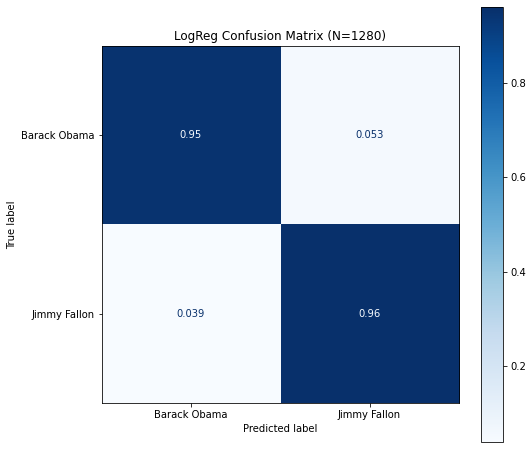

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(8,8))
plot_confusion_matrix(log_reg, X_test, y_test, 
                      normalize='true', cmap='Blues', 
                      display_labels=['Barack Obama', 'Jimmy Fallon'], ax=ax)
plt.title(f'LogReg Confusion Matrix (N={X_test.shape[0]})');

In [17]:
import spacy

# Load SpaCy pre-trained model
nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser'])

def vectorize_tweet(nlp, tweet_text):
    '''This function returns the SpaCy embeddings for an input text'''
    return list(nlp(tweet_text).vector)

In [18]:
new_embedding = vectorize_tweet(nlp, "The innovation displayed during this pandemic is unprecedented.")
new_embedding[0:5]

[-0.11192022, 0.27545333, 0.17263512, -0.096563116, -0.06543166]

In [22]:
log_reg.predict([new_embedding])

array([1.])

In [24]:
pickle.dump(log_reg, open("log_reg.pkl", "wb"))

In [25]:
unpickled_lr = pickle.load(open("log_reg.pkl", "rb"))
unpickled_lr.predict([new_embedding])

array([1.])